In [1]:
from urllib.request import urlopen

import numpy as np
import pandas as pd
import datetime
import cartopy
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import aacgmv2

from harc_plot import gen_lib
geopack = gen_lib.geopack

Re = 6371

%matplotlib inline

resetting environment variable IGRF_COEFFS in python script
resetting environment variable AACGM_v2_DAT_PREFIX in python script
non-default coefficient files may be specified by running aacgmv2.wrapper.set_coeff_path before any other functions


In [2]:
#mpl.rcParams['font.size']      = 18
#mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = np.array([15, 8])
mpl.rcParams['axes.xmargin']   = 0

In [3]:
dt     = datetime.datetime(2017,11,3,10)
height = 110.

# AACGM Testing

In [4]:
lat  = 60.
lons = np.arange(-180,180,30)

df_lst = []
for lon in lons:
    
    lon_hr = lon/15.
    lt     = dt + datetime.timedelta(hours=lon_hr)
    
    mlat,mlon,out_r = aacgmv2.convert_latlon(lat,lon,height,dt)
    mlt_hr = aacgmv2.convert_mlt(mlon,dt)[0]
    mlt    = datetime.time(int(mlt_hr),int((mlt_hr-int(mlt_hr))*60.))
    
    tmp = {'UT':dt,'lat':lat,'lon':lon,'lon_hr':lon_hr,'LT':lt,'mlat':mlat,'mlon':mlon,'MLT':mlt,'LT':lt}
    df_lst.append(tmp)
    
df_mag = pd.DataFrame(df_lst)
df_mag

,UT,lat,lon,lon_hr,LT,mlat,mlon,MLT
0,2017-11-03 10:00:00,60.0,-180,-12.0,2017-11-02 22:00:00,55.769703,-116.110055,21:45:00
1,2017-11-03 10:00:00,60.0,-150,-10.0,2017-11-03 00:00:00,59.897313,-91.694162,23:23:00
2,2017-11-03 10:00:00,60.0,-120,-8.0,2017-11-03 02:00:00,65.580217,-61.030215,01:26:00
3,2017-11-03 10:00:00,60.0,-90,-6.0,2017-11-03 04:00:00,69.022592,-18.489788,04:16:00
4,2017-11-03 10:00:00,60.0,-60,-4.0,2017-11-03 06:00:00,66.358479,25.108587,07:10:00
5,2017-11-03 10:00:00,60.0,-30,-2.0,2017-11-03 08:00:00,60.997255,55.931277,09:13:00
6,2017-11-03 10:00:00,60.0,0,0.0,2017-11-03 10:00:00,57.635210,80.555750,10:52:00
7,2017-11-03 10:00:00,60.0,30,2.0,2017-11-03 12:00:00,56.773460,105.936869,12:33:00
8,2017-11-03 10:00:00,60.0,60,4.0,2017-11-03 14:00:00,56.787082,133.956536,14:25:00
9,2017-11-03 10:00:00,60.0,90,6.0,2017-11-03 16:00:00,56.539327,163.995961,16:26:00


# AACGMv2 Lat-Lon Grid

In [5]:
def calc_mlat_lines(mlat_ticks=np.arange(50,90,10),mlt_lim=None,height=0.):
    mlons      = np.arange(-180,180,1)

    mlat_lines = {}
    for mlat_tick in mlat_ticks:
        mlats  = np.ones(len(mlons),dtype=float)*mlat_tick
        glats, glons, r_out = aacgmv2.convert_latlon_arr(mlats,mlons,height,dt,'A2G')

        if mlt_lim is not None:
            mlon_lim = aacgmv2.convert_mlt(mlt_lim,dt,True)
            glat_lim, glon_lim, _ = aacgmv2.convert_latlon_arr([mlat_tick,mlat_tick],mlon_lim,height,dt,'A2G')
            
            tf = np.logical_and(glons >= glon_lim[0], glons < glon_lim[1])
            glons = glons[tf]
            glats = glats[tf]        

        srt = np.argsort(glons)
        glons = glons[srt]
        glats = glats[srt]
                
        tmp = {'glats':glats,'glons':glons}

        mlat_lines[mlat_tick] = tmp
    return mlat_lines

In [6]:
def calc_mlt_lines(mlt_ticks,mlat_lim=(0,90),height=0.):
    mlats     = np.arange(mlat_lim[0],mlat_lim[1]+1,1)

    mlt_lines = {}
    for mlt_tick in mlt_ticks:
        mlon  = aacgmv2.convert_mlt(mlt_tick,dt,True)
        mlons = np.ones(len(mlats),dtype=float)*mlon
        glats, glons, r_out = aacgmv2.convert_latlon_arr(mlats,mlons,height,dt,'A2G')

        srt = np.argsort(glats)
        glons = glons[srt]
        glats = glats[srt]
        tmp = {'glats':glats,'glons':glons}

        mlt_lines[mlt_tick] = tmp
    return mlt_lines

In [7]:
mlat_ticks = np.arange(50,90,10)
mlat_lines = calc_mlat_lines(mlat_ticks)

mlt_ticks = np.arange(0,24,3)
mlat_lim  = (mlat_ticks.min(),mlat_ticks.max())
mlt_lines = calc_mlt_lines(mlt_ticks,mlat_lim)

# SME Enhancement Boundaries

In [8]:
# SME actually takes contributions from all magnetometers between 40 and 80 deg MLAT.
# https://supermag.jhuapl.edu/indices/?layers=SME.UL&fidelity=low&start=2001-01-30T05%3A00%3A00.000Z&step=14400&tab=description

mlt_lim   = (22,4)
mlat_lim  = (60,80)

sme_mlat_lines = calc_mlat_lines(mlat_lim,mlt_lim=mlt_lim,height=110)
sme_mlt_lines  = calc_mlt_lines(mlt_lim,mlat_lim,height=110)

# Geographic Data and Calculations

In [9]:
sites = {}

key = 'pfisr'
s   = sites[key] = {}
s['glat']   =  65.12992
s['glon']   = -147.47104
s['label']  = 'PFISR'
s['marker'] = '^'
s['size']   = 350

key = 'tid'
s   = sites[key] = {}
s['glat']   =  44.
s['glon']   = -93.
s['label']  = 'TID Observation'
s['marker'] = 'o'
s['size']   = 250

In [10]:
cases = []
cases.append({'t_hr':2, 'v_p': 1100})
cases.append({'t_hr':3, 'v_p': 1100})
cases.append({'t_hr':2, 'v_p': 1220})
cases.append({'t_hr':3, 'v_p': 1220})

azm = 180+163

colors = 'bgrcmyk'
for inx,case in enumerate(cases):
    t_hr = case['t_hr']
    v_p  = case['v_p']

    rgc = t_hr * v_p
    src_lat, src_lon = geopack.greatCircleMove(sites['tid']['glat'],sites['tid']['glon'],rgc,azm)

    src_lat = src_lat[0]
    src_lon = src_lon[0]

    key = 'src_t{:d}v{:d}'.format(t_hr,v_p)
    s   = sites[key] = {}
    s['glat']   = src_lat
    s['glon']   = src_lon
    s['label']  = '{!s} hr {!s} km/hr'.format(t_hr,v_p)
    s['marker'] = '*'
    s['size']   = 500
    s['color']  = colors[inx]

In [11]:
# Calculate Magnetic Coordinates
for site_key,site in sites.items():
    glat = site['glat']
    glon = site['glon']
    
    mlat, mlon, _ = aacgmv2.convert_latlon(glat,glon,0.,dt)
    mlt_hr        = aacgmv2.convert_mlt(mlon,dt)
    mlt           = datetime.time(int(mlt_hr),int((mlt_hr-int(mlt_hr))*60.))
    
    site['mlat']  = mlat
    site['mlon']  = mlon
    site['MLT']   = mlt

In [12]:
site_keys = []
site_lst  = []
for site_key,site in sites.items():
    site_keys.append(site_key)
    site_lst.append(site)
site_df = pd.DataFrame(site_lst,site_keys)

In [13]:
site_df

,glat,glon,label,marker,size,mlat,mlon,MLT,color
pfisr,65.129920,-147.471040,PFISR,^,350,65.335605,-92.075228,23:21:00,NaN
tid,44.000000,-93.000000,TID Observation,o,250,53.455759,-21.986230,04:02:00,NaN
src_t2v1100,62.437166,-105.349693,2 hr 1100 km/hr,*,500,70.027928,-42.552844,02:39:00,b
src_t3v1100,70.757662,-119.055592,3 hr 1100 km/hr,*,500,75.808583,-67.055255,01:01:00,g
src_t2v1220,64.342413,-107.615417,2 hr 1220 km/hr,*,500,71.530808,-46.629689,02:23:00,r
src_t3v1220,73.128101,-126.188908,3 hr 1220 km/hr,*,500,76.848394,-78.644765,00:15:00,c


# Plot Map

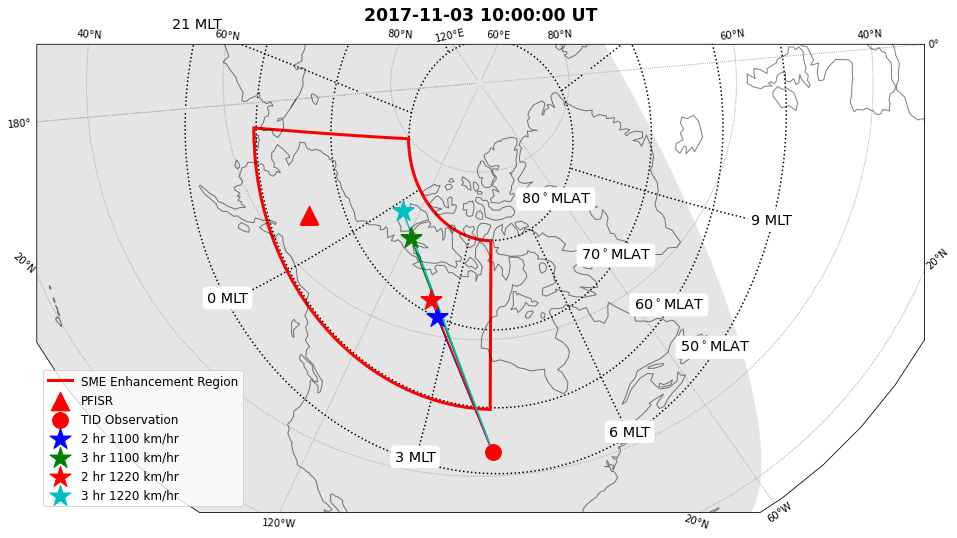

In [14]:
fig = plt.figure(figsize=(35,35))
projection = ccrs.Orthographic(-95, 90)
data_crs   = ccrs.PlateCarree()

ax  = fig.add_subplot(1, 2, 1, projection=projection)

ax.coastlines(zorder=3,alpha=0.5)
#ax.stock_img()
ax.gridlines()
ax.add_feature(Nightshade(dt,alpha=0.1))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

grd_kwargs = {}
grd_kwargs['ls']        = ':'
grd_kwargs['color']     = 'k'
grd_kwargs['transform'] = data_crs

lbl_kwargs = {}
lbl_kwargs['transform'] = data_crs
lbl_kwargs['ha']        = 'center'
lbl_kwargs['fontdict']  = {'size':'x-large'}
lbl_kwargs['bbox']      = {'facecolor':'w','edgecolor':'None','boxstyle':'round'}
lbl_kwargs['zorder']    = 4
lbl_kwargs['clip_on']   = True

sme_kwargs = {}
sme_kwargs['ls']        = '-'
sme_kwargs['lw']        = 3
sme_kwargs['color']     = 'r'
sme_kwargs['transform'] = data_crs

# Plot magnetic latitude grid.
for mlat,mlat_line in mlat_lines.items():
    xx = mlat_line['glons']
    yy = mlat_line['glats']
    ax.plot(xx,yy,**grd_kwargs)
    
    lbl_mlon = aacgmv2.convert_mlt(7.5,dt,True)
    lbl_glat, lbl_glon, _ = aacgmv2.convert_latlon(mlat,lbl_mlon,0,dt,'A2G')
    ax.text(lbl_glon,lbl_glat,'${!s}^\circ$MLAT'.format(mlat),**lbl_kwargs)
    
# Plot MLT grid.
for mlt,mlt_line in mlt_lines.items():
    xx = mlt_line['glons']
    yy = mlt_line['glats']
    
    tf = xx <= 0.
    ax.plot(xx[tf],yy[tf],**grd_kwargs)
    
    tf = xx >= 0.
    ax.plot(xx[tf],yy[tf],**grd_kwargs)
    
    ax.text(xx[0],yy[0],'{!s} MLT'.format(mlt),**lbl_kwargs)

# Plot SME magnetic boundaries.
for sme_inx,(mlat,mlat_line) in enumerate(sme_mlat_lines.items()):
    xx = mlat_line['glons']
    yy = mlat_line['glats']
    if sme_inx == 0:
        lbl = 'SME Enhancement Region'
    else:
        lbl = None
    ax.plot(xx,yy,label=lbl,**sme_kwargs)

for mlt,mlt_line in sme_mlt_lines.items():
    xx = mlt_line['glons']
    yy = mlt_line['glats']
    
    tf = xx <= 0.
    ax.plot(xx[tf],yy[tf],**sme_kwargs)
    
    tf = xx >= 0.
    ax.plot(xx[tf],yy[tf],**sme_kwargs)
    

for site_key,site in sites.items():
    glat = site['glat']
    glon = site['glon']
    
    kw   = {}
    kw['transform'] = data_crs
    kw['fc']        = site.get('color','r')
    kw['label']     = site.get('label')
    kw['marker']    = site.get('marker','o')
    kw['s']         = site.get('size',250)
    kw['zorder']    = 100

    ax.scatter(glon,glat,**kw)
    
    if 'src_' in site_key:
        ax.plot([glon,sites['tid']['glon']],[glat,sites['tid']['glat']],
                transform=ccrs.Geodetic(),color=site.get('color','b'))


ax.set_extent((-180,0,30,90), crs = data_crs)
ax.legend()
ax.set_title('{!s} UT'.format(dt))
plt.show()

# PFISR MLT Table

In [15]:
dtime = datetime.timedelta(hours=1)
sTime = datetime.datetime(2017,11,3,8)
eTime = datetime.datetime(2017,11,3,13)
times = [sTime]
while times[-1] < eTime:
    times.append(times[-1]+dtime)

site = 'pfisr'
mlat = site_df.loc[site]['mlat']
mlon = site_df.loc[site]['mlon']
mlt_lst = []
for time in times:
    tmp = {}
    

   
    mlt_hr = aacgmv2.convert_mlt(mlon,time)[0]
    mlt    = datetime.time(int(mlt_hr),int((mlt_hr-int(mlt_hr))*60.))
    
    tmp = {'site':site,'UT':time,'mlat':mlat,'mlon':mlon,'MLT':mlt}
    mlt_lst.append(tmp)
    
mlt_df = pd.DataFrame(mlt_lst)
mlt_df

,site,UT,mlat,mlon,MLT
0,pfisr,2017-11-03 08:00:00,65.335605,-92.075228,21:24:00
1,pfisr,2017-11-03 09:00:00,65.335605,-92.075228,22:22:00
2,pfisr,2017-11-03 10:00:00,65.335605,-92.075228,23:21:00
3,pfisr,2017-11-03 11:00:00,65.335605,-92.075228,00:24:00
4,pfisr,2017-11-03 12:00:00,65.335605,-92.075228,01:27:00
5,pfisr,2017-11-03 13:00:00,65.335605,-92.075228,02:29:00
